# COMP 472 - AI
## Assignment #1 - due 21/02/2021
## Authors:
### Dan Raileanu (40019882)
### Laurentiu Trifan (40044651)
### Jonathan Andrei (40051683)

### Note to marker:
Please don't run notebook right away, Best-DT can take a long time to run, so we ran it to get output files and show plots in Notebook.<br>
Feel free to run it after going through it, just delete all our output files and we recomend changing the variable dataset_name below to a smaller dataset file. <br>
The variable below is for the file used for training and testing. If you simply want to test, go at the end of notebook in DEMO section.

In [1]:
dataset_name = "dataset"

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
from sklearn import tree, naive_bayes
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from collections import Counter

# Task 0

In [3]:
def read_documents(doc_file):
    """
        Reads doc_file and returns 3 lists of same length.
        rowNums contains row index of each document
        docs contains lists of strings of every word in each document(separation by whitespace)
        labels contains label of each document, where we assume it's the second word on every line
    """
    rowNums = []
    docs = []
    labels = []
    with open(doc_file, encoding = "ISO-8859-1") as f:
        row = 0
        for line in f:
            row+=1
            words = line.strip().split()
            rowNums.append(row)
            docs.append(words[3:])
            labels.append(words[1])
    return rowNums, docs, labels

In [4]:
all_rowNums, all_docs, all_labels = read_documents("{}.txt".format(dataset_name))
#randomly shuffle and split documents in train/test sets
train_rows, eval_rows,\
     train_docs, eval_docs,\
     train_labels, eval_labels = sklearn.model_selection.train_test_split(all_rowNums, all_docs, all_labels, test_size=0.2, random_state=8)

In Task 2, we were able to implement the Naive Bayes algorithm that accepts the above structure of train_docs and eval_docs, that is a list of list of strings.<br>
However, sklearn's classifiers require continous numeric values as features, thus we have to convert them to a frequency count matrix.<br>
We used CountVectorizer to achieve this. As a sanity check, we will later test both the manual implementation of Naive Bayes and sklearn's Naive Bayes to see that they are the same.

In [5]:
#first append all word strings into one long document string for each doc
train_strings = [' '.join(doc) for doc in train_docs]
eval_strings = [' '.join(doc) for doc in eval_docs]
#convert training set strings to feature matrix using CountVectorizer
cv = CountVectorizer(token_pattern = r"\S+") #a word is any sequence of non-whitespace characters
cv_train = cv.fit_transform(train_strings)
train_feat = cv_train.toarray()
#only transform and not fit for eval_strings, since want to keep same vocabulary as training
cv_eval = cv.transform(eval_strings)
eval_feat = cv_eval.toarray()

# Task 1

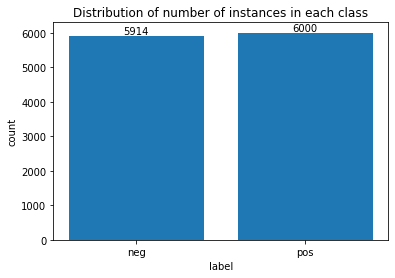

In [6]:
labels_count = np.array([[label, all_labels.count(label)] for label in set(all_labels)])
labels_list = labels_count[:,0]
count_list = labels_count[:,1].astype(np.int)
plt.bar(labels_list, count_list)
plt.xlabel("label")
plt.ylabel("count")
plt.title("Distribution of number of instances in each class")
# display values above bars
for i in range(len(count_list)):
    plt.annotate(str(count_list[i]), xy=(labels_list[i],count_list[i]), ha='center', va='bottom')

# TASK 2
## Naive Bayes
First our manual implementation of Naive Bayes algorithm. 

In [7]:
def train_nb(documents, labels, smooth=0.0):
    """
        Using Naive Bayes Algorithm, computes proabilities of every word given a label, as well as the class proability of label.
        By default, does not apply smoothing.
        returns NB_probs::={<label>: [<label_prob>, <words|label>]}
        where <words|label>::={<word>:<word_freq>}
    """
    NB_probs = dict() #returned dict
    labels_set = set(labels)
    vocabulary = set([j for i in documents for j in i])#flattens documents and keeps unique values
    vocabulary_size = len(vocabulary)

    for label in labels_set:
        #get only documents for given label
        label_docs = [doc for idx,doc in enumerate(documents) if labels[idx]==label]

        words_freq = Counter()
        #first apply smoothing, while also ensuring that every word in vocabulary gets added
        for word in vocabulary:
            words_freq[word]=smooth
        #add frequency of every word in documents of given label
        for doc in label_docs:
            words_freq.update(doc) 
        words_total = sum(words_freq.values()) #total nb of words in documents of given label(smoothing already included)

        #compute P(word|label) for every word in filtered documents
        words_prob = dict()
        for word,freq in words_freq.items():
            words_prob[word] = freq / words_total #smoothing is already applied!
        #compute P(label)
        label_prob = len(label_docs) / len(documents)
        NB_probs[label] = [label_prob, words_prob]
    return NB_probs
    
def test_nb(document, NB_probs):
    """
        Classifies document according to probabilities computed in train_nb()
        Uses log of probabilities to avoid underflow. Ignores words in document that are not part of vocabulary obtained from training
        Returns label with highest probability
    """
    scores = dict()
    for label,(label_prob,words_prob) in NB_probs.items():
        score = np.log(label_prob)
        for word in document:
            if word in words_prob:
                score += np.log(words_prob[word])
        scores[label] = score
    return max(scores, key=scores.get)

In [8]:
NB_probs = train_nb(train_docs, train_labels, 0.75)

In [9]:
#compute accuracy
count = 0
for doc,label in zip(eval_docs,eval_labels):
    pred = test_nb(doc, NB_probs)
    if pred==label:
        count+=1
manual_nb_accuracy = count / len(eval_docs)

As a sanity check, use sklearn's Naive Bayes and compare accuracies

In [10]:
nb_model = sklearn.naive_bayes.MultinomialNB(alpha=0.75)
nb_model.fit(train_feat, train_labels)
nb_accuracy = nb_model.score(eval_feat, eval_labels)
print("Manual NB accuracy:\t{:%}\nSklearn's NB accuracy:\t{:%}".format(manual_nb_accuracy, nb_accuracy))

Manual NB accuracy:	79.143936%
Sklearn's NB accuracy:	79.143936%


## Base-DT

In [11]:
base_dt_model = sklearn.tree.DecisionTreeClassifier(criterion='entropy', random_state=8)
base_dt_model.fit(train_feat, train_labels)
base_dt_accuracy = base_dt_model.score(eval_feat, eval_labels)
print("Base-DT accuracy:\t{:%}".format(base_dt_accuracy))

Base-DT accuracy:	67.058330%


### Before getting to the Best-DT, let's try to improve our current accuracies

# Task 2.5 (extra optimization)
The current models used an alphabet were each word was a sequence of non-whitespace characters. Below we write to a file to see word counts for each class on training data.<br>

In [12]:
with open("non-whitespace-word-count.txt", 'w') as f:
    feat_count = nb_model.feature_count_.T
    vocab = cv.get_feature_names()
    for word, row in zip(vocab,feat_count):
        f.write("{:.0f}\t{:.0f}\t".format(row[0],row[1]))
        f.write(word+"\n")


Looking at that file, we see that we have words like "...he","..and" and "[it" as part of our vocabulary.<br>
Furthermore, we suspect that words made out of numbers are also not relevant with the current task of determining positive/negative sentiment.<br>
These are likely to just cause noise and not translate well to test data. So let's change our vocabulary to only include alphabetical characters.

In [13]:
old_vocab_size = len(vocab)
cv = CountVectorizer(token_pattern = r'(?u)\b[A-Za-z]+\b') #a word is any sequence of letters
cv_train = cv.fit_transform(train_strings)
train_feat = cv_train.toarray()
#only transform and not fit for eval_strings, since want to keep same vocabulary as training
cv_eval = cv.transform(eval_strings)
eval_feat = cv_eval.toarray()
vocab = cv.get_feature_names()

In [14]:
print("Old vocabulary size:{}\nNew vocabulary size:{}".format(old_vocab_size, len(vocab)))

Old vocabulary size:52457
New vocabulary size:40769


In [15]:
nb_model = sklearn.naive_bayes.MultinomialNB(alpha=0.75)
nb_model.fit(train_feat, train_labels)
nb_accuracy_new = nb_model.score(eval_feat, eval_labels)
print("NB accuracy(old):\t{:%}\nNB accuracy(new):\t{:%}".format(nb_accuracy, nb_accuracy_new))

NB accuracy(old):	79.143936%
NB accuracy(new):	79.605539%


In [16]:
base_dt_model = sklearn.tree.DecisionTreeClassifier(criterion='entropy', random_state=8)
base_dt_model.fit(train_feat, train_labels)
base_dt_accuracy_new = base_dt_model.score(eval_feat, eval_labels)
print("Base-DT accuracy(old):\t{:%}\nBase-DT accuracy(new):\t{:%}".format(base_dt_accuracy, base_dt_accuracy_new))

Base-DT accuracy(old):	67.058330%
Base-DT accuracy(new):	68.233319%


In [33]:
#get word counts using new vocabulary
with open("letter-only-word-count.txt", 'w') as f:
    feat_count = nb_model.feature_count_.T
    vocab = cv.get_feature_names()
    for word, row in zip(vocab,feat_count):
        f.write("{:.0f}\t{:.0f}\t".format(row[0],row[1]))
        f.write(word+"\n")

The optimization didn't seem to have much of a difference. Since we randomly shuffle our training/evaluation data, on certain runs the accuracy increased, but on others it decreased, however always by at most 1%. <br>
Even though the vocabulary decreased from about 52k to 40k, the words containing symbols/numbers often had either a low frequency or same frequency for both classes. When it comes to numbers, we could have \$350 be only seen in pos documents, but \$370 only in negatives, it's possible that these biases would cancel each other out in the end. It's still surprising though that the results remained so similar after optimizing the vocabulary, we expected at least a small noticeable improvement.<br>
Although we got similar results, we decided to keep the vacabulary of only alphabet words, since it makes more semantical sense.

## Finding optimal smoothing parameter for NB
Another optimization we could do is finding the best smoothing for NB. Normally we could use GridSearchCV, but we wanted to get accuracies for each value.

In [17]:
smooth_list = np.arange(0.5, 3.1, 0.1)
smooth_list = np.around(smooth_list, decimals=1) #to avoid values like 1.20000000002
nb_estimators = []
nb_accuracies = np.empty((len(smooth_list), 2))

for i, smooth in enumerate(smooth_list):
    estimator = sklearn.naive_bayes.MultinomialNB(alpha=smooth)
    estimator.fit(train_feat, train_labels)
    nb_estimators.append(estimator)

    nb_accuracies[i,0] = sklearn.metrics.accuracy_score(train_labels, estimator.predict(train_feat))
    nb_accuracies[i,1] = sklearn.metrics.accuracy_score(eval_labels, estimator.predict(eval_feat))
    print("Finished training/testing using smoothness:{}".format(smooth))

Finished training/testing using smoothness:0.5
Finished training/testing using smoothness:0.6
Finished training/testing using smoothness:0.7
Finished training/testing using smoothness:0.8
Finished training/testing using smoothness:0.9
Finished training/testing using smoothness:1.0
Finished training/testing using smoothness:1.1
Finished training/testing using smoothness:1.2
Finished training/testing using smoothness:1.3
Finished training/testing using smoothness:1.4
Finished training/testing using smoothness:1.5
Finished training/testing using smoothness:1.6
Finished training/testing using smoothness:1.7
Finished training/testing using smoothness:1.8
Finished training/testing using smoothness:1.9
Finished training/testing using smoothness:2.0
Finished training/testing using smoothness:2.1
Finished training/testing using smoothness:2.2
Finished training/testing using smoothness:2.3
Finished training/testing using smoothness:2.4
Finished training/testing using smoothness:2.5
Finished trai

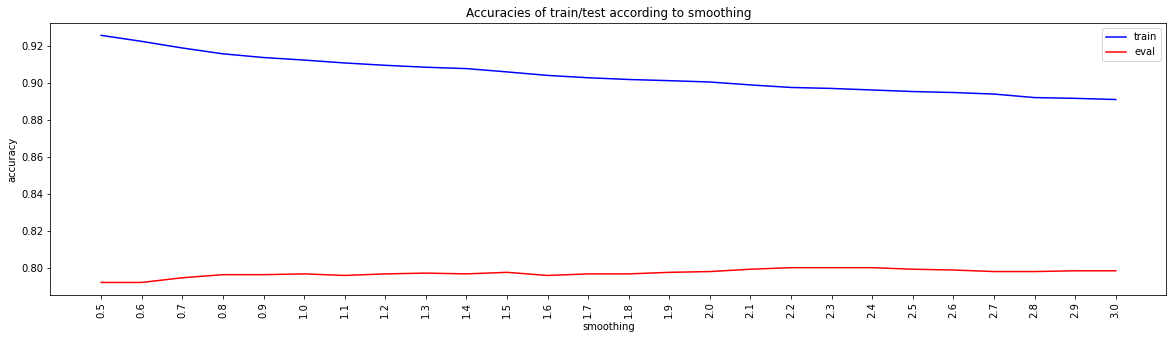

In [18]:
plt.figure(figsize=(20,5))
plt.plot(nb_accuracies[:,0], color='b', label='train')
plt.plot(nb_accuracies[:,1], color='r', label='eval')
plt.xticks(range(len(smooth_list)), labels=smooth_list, rotation='vertical')
plt.xlabel('smoothing')
plt.ylabel('accuracy')
plt.title("Accuracies of train/test according to smoothing")
plt.legend()

In [19]:
# get best naive bayes model
best_nb_index_train = nb_accuracies[:,0].argmax()
best_nb_index_eval = nb_accuracies[:,1].argmax()
nb_model = nb_estimators[best_nb_index_train]
nb_model_alt = nb_estimators[best_nb_index_eval] #keeping only for demo, assuming that the current eval data was actually validation

In [20]:
print("Best NB smoothness using train data:{}".format(nb_model.get_params()['alpha']))
print("Best NB smoothness using eval data:{}".format(nb_model_alt.get_params()['alpha']))

Best NB smoothness using train data:0.5
Best NB smoothness using eval data:2.2


## Best-DT
Hypyerparameter search on DecisionTreeClassifier.<br>
Normally we would use GridSearchCV, but we wanted to keep all estimators for scoring purposes, so we will just manually implement it.

In [21]:
max_depth_grid = [1, 5, 15, 30, 40, None]
min_samples_leaf_grid = [1, 3, 5, 10, 20]
best_dt_estimators = [] #list of all estimators resulting from gridsearch
best_dt_accuracies = np.empty((len(max_depth_grid), len(min_samples_leaf_grid), 2)) #2 for train and test score

for i, max_depth in enumerate(max_depth_grid):
    for j, min_samples_leaf in enumerate(min_samples_leaf_grid):
        estimator = sklearn.tree.DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=8)
        estimator.fit(train_feat, train_labels)
        best_dt_estimators.append(estimator)

        best_dt_accuracies[i,j,0] = sklearn.metrics.accuracy_score(train_labels, estimator.predict(train_feat))
        best_dt_accuracies[i,j,1] = sklearn.metrics.accuracy_score(eval_labels, estimator.predict(eval_feat))
        print("Finished training/testing with max_depth:{}\t and min_samples_leaf:{}".format(max_depth, min_samples_leaf))

Finished training/testing with max_depth:1	 and min_samples_leaf:1
Finished training/testing with max_depth:1	 and min_samples_leaf:3
Finished training/testing with max_depth:1	 and min_samples_leaf:5
Finished training/testing with max_depth:1	 and min_samples_leaf:10
Finished training/testing with max_depth:1	 and min_samples_leaf:20
Finished training/testing with max_depth:5	 and min_samples_leaf:1
Finished training/testing with max_depth:5	 and min_samples_leaf:3
Finished training/testing with max_depth:5	 and min_samples_leaf:5
Finished training/testing with max_depth:5	 and min_samples_leaf:10
Finished training/testing with max_depth:5	 and min_samples_leaf:20
Finished training/testing with max_depth:15	 and min_samples_leaf:1
Finished training/testing with max_depth:15	 and min_samples_leaf:3
Finished training/testing with max_depth:15	 and min_samples_leaf:5
Finished training/testing with max_depth:15	 and min_samples_leaf:10
Finished training/testing with max_depth:15	 and min_

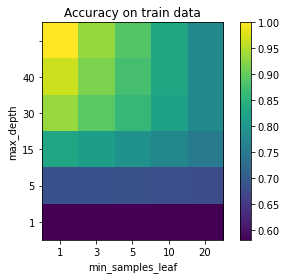

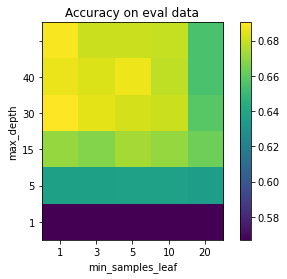

In [22]:
for i, name in enumerate(['train', 'eval']):
    plt.figure()
    plt.imshow(best_dt_accuracies[:,:,i], origin='lower')
    plt.colorbar();
    plt.xlabel('min_samples_leaf')
    plt.ylabel('max_depth')
    plt.xticks(range(len(min_samples_leaf_grid)), labels=min_samples_leaf_grid)
    plt.yticks(range(len(max_depth_grid)), labels=max_depth_grid)
    plt.title("Accuracy on %s data" % name)

In [23]:
best_dt_index_train = best_dt_accuracies[:,:,0].argmax()
best_dt_index_eval = best_dt_accuracies[:,:,1].argmax()
best_dt_model = best_dt_estimators[best_dt_index_train]
best_dt_model_alt = best_dt_estimators[best_dt_index_eval]

In [25]:

print("Best DT parameters using train data:\n'max_depth'={}, 'min_samples_leaf'={}".format(best_dt_model.get_params()['max_depth'], best_dt_model.get_params()['min_samples_leaf']))
print("Best DT smoothness using eval data:\n'max_depth'={}, 'min_samples_leaf'={}".format(best_dt_model_alt.get_params()['max_depth'], best_dt_model_alt.get_params()['min_samples_leaf']))

Best DT parameters using train data:
'max_depth'=None, 'min_samples_leaf'=1
Best DT smoothness using eval data:
'max_depth'=30, 'min_samples_leaf'=1


# Task 3

In [31]:
def test_model(Model, indexes, features, labels, dataset_name, model_name):
    """
        Uses provided sklearn Model to generate predictions. Model must have method predict(X)
        Obtains confusion matrix, precision, recall and f1 measure for each class, as well as accuracy.
        Writes results to a file called "[model-name]-[dataset-name].txt"
    """
    predictions = Model.predict(features)
    accuracy = sklearn.metrics.accuracy_score(labels, predictions)
    confusion_matrix = sklearn.metrics.confusion_matrix(labels, predictions)
    label_names = sorted(set(labels))#sorting because confusion matrix has them in sorted order
    other_stats = []#precision, recall and f1 measure for each class
    for index,row in enumerate(confusion_matrix): #not assuming only 2 labels
        tp = confusion_matrix[index,index] #always along diagonal
        other_indexes = [i for i in range(0, len(label_names)) if i!=index] #list of all other indexes for fp/fn
        fp = np.sum(confusion_matrix[other_indexes, index])
        fn = np.sum(confusion_matrix[index, other_indexes])

        precision = tp / (tp+fp)
        recall = tp / (tp+fn)
        f1 = (2*precision*recall) / (precision+recall)
        other_stats.append([precision, recall, f1])
    

    #get Pandas dataframe for confusion matrix, as prettier to display in txt file
    labels_true = pd.Series(labels, name='True')
    labels_pred = pd.Series(predictions, name='Predicted')
    confusion_df = pd.crosstab(labels_true, labels_pred)

    #convert label names to indexes in predictions list (don't like it but assignment asks for it..)
    labels_dict = {label: index for index, label in enumerate(label_names)}
    predictions_alt = [labels_dict[label] for label in predictions]

    # write results to new file
    with open("[{}]-[{}].txt".format(model_name, dataset_name), 'w') as f:
        f.write("Accuracy of {}: {:%}\n".format(model_name, accuracy))
        f.write("===== Confusion Matrix =====\n{}\n".format(confusion_df.to_string()))
        f.write("===== Precision/Recall/F1 measure =====\n")
        for label, stats in zip(label_names, other_stats):
            f.write("Label:\t\t {}\nPrecision:\t {:.2%}\nRecall:\t\t {:.2%}\nF1 measure:\t {:.2%}\n\n".format(label, stats[0], stats[1], stats[2]))
        f.write("===== Predictions =====\nLabels to index mapping: {}\n".format(labels_dict))
        for row, pred in sorted(zip(indexes, predictions_alt)):
            f.write("{},{}\n".format(row,pred))
    
    #optional display confusion matrix in notebook
    conf_matrix_display = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix, display_labels=label_names)
    conf_matrix_display.plot(values_format='d')
    plt.title("Confusion Matrix for {}".format(model_name))


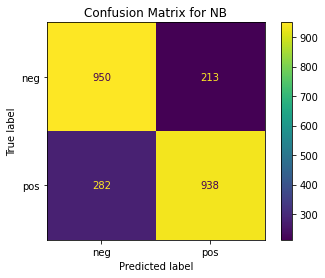

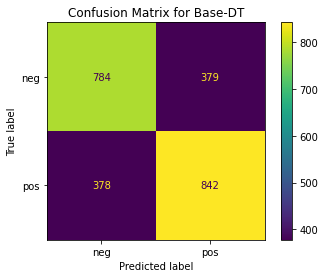

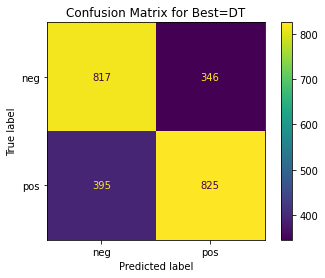

In [32]:
test_model(nb_model, eval_rows, eval_feat, eval_labels, dataset_name, 'NB')
test_model(base_dt_model, eval_rows, eval_feat, eval_labels, dataset_name, 'Base-DT')
test_model(best_dt_model, eval_rows, eval_feat, eval_labels, dataset_name, 'Best=DT')

# Task 4
To get idea why we might have missclassified some documents, we wrote the function below.<br>

In [36]:
def analyze_errors(Model, indexes, features, labels, docs, vocab, dataset_name, docs_to_analyze=10):
    """
        Writes to a file data to get idea on how prediction might have gone wrong.
        File will have following format:
            <doc index> <label> <prediction> <prediction probabilities, neg vs pos>
            <document string>
            <table with columns: [word, freq_in_doc, freq_in_neg_docs, freq_in_pos_docs]>
        Note that last table is sorted according to maximum difference in prediction probability, as those are most important features.
    """
    #get only missclassified documents
    pred = Model.predict(features)
    pred_prob = Model.predict_proba(features)
    zipped_data = list(zip(indexes, features, labels, pred, pred_prob, docs)) #zip data for filtering
    zipped_data = [item for item in zipped_data if item[2]!=item[3]] # keep only wrongly classified documents
    zipped_data.sort(reverse=True, key=lambda item: max(item[4][0], item[4][1])) # sort according to difference in prediction probabilities
    feat_count = Model.feature_count_.T.astype(np.int) # how often each feature appears in neg/pos documents

    #write results to file
    with open("[error-analysis]-[{}]-[{}].txt".format(Model.__class__.__name__, dataset_name), 'w') as f:
        for i,item in enumerate(zipped_data):
            if i < docs_to_analyze:
                #general info about prediction
                f.write("index:{}\tlabel:{}\tpred:{}\tpred_prob: {:.2f} vs {:.2f}\n{}\n\n".format(item[0],item[2],item[3], item[4][0], item[4][1], item[5]))
                f.write("Feature words extracted from documents and frequency that they appeared in neg/pos documents in training:\n")
                f.write("Sorted according to maximum relative difference between P(word | label)\n")
                
                #table with how each word in document appeared in training neg/pos samples
                feature_data = list(zip(vocab, item[1], feat_count[:,0], feat_count[:,1]))
                feature_data = [row for row in feature_data if row[1]!=0]
                feature_data.sort(reverse=True, key=lambda row: abs((row[2]-row[3])/(row[2]+row[3])))
                df = pd.DataFrame(feature_data, columns=["word", "freq in doc", "freq in neg docs", "freq in pos docs"])
                f.write(df.to_string())
                f.write("\n======================================================================================================\n\n")


In [37]:
analyze_errors(nb_model, eval_rows, eval_feat, eval_labels, eval_strings, vocab, dataset_name)

We can look at the generated file "\[error-analysis\]-\[MultinomialNB\]-\[dataset\].txt" to get an idea why we might have missclassified some documents<br><br>
First we have file at index 4846 that was classified as "neg" instead of "pos", with 100% probability that it should be "neg".<br>
Going through the list of words appearing in the file, we can see that most appeared more often in "neg" labelled documents. Some of them have a clear negative connotation such as: "uninstall", "trash", "expired", "problem", "junk" and "malware". <br>
Some words seem to have been seen more often in "neg" documents, even though they don't seem to have a negative connotation, such as "router", "sent", "installs", "actual", "would" and "they". <br>
There are many words that appear more often under "pos" as well, but for the most part the words encountered were previously seen in "neg" documents, or they equally in both labels.


Document at index 9763 was missclassified as "pos" instead of "neg", also with 100% probability.<br>
Going through the words in the document, it was at first somewhat surprising that it was classified as "pos" with 100% certainity. There are clearly many words that were encountered more often in "neg" documents. However, even though those words have a high frequency count in "neg" documents, they still appear somewhat often in "pos" documents, so the relative relative difference isn't as high. For example the word "bad" appears in the document, this word appeared 741 times in "neg" documents and 248 times in "pos" documents. That means that P("bad"|"neg") is only about 3 times higher than P("good"|"pos").<br>
Now if we look at the first 19 words in the analysis for that document, we see that they often never appear in "neg", or maybe once. On the other hand, them appearing 2-18 times in "pos", makes the P(word|"pos") much higher compared to P(word|"neg"). The best model used had only 0.5 smoothing, thus it wasn't infinitely higher, but having so many words with a relatively higher frequency in "pos" documents must have dramatically increased the chance of the document being "pos".

One thing to note though, is that the Naive-Bayes model used for the analysis above was the one that had best smoothing on training data, thus ofcourse it took the lowest smoothing provided and ended up overfitting.<br>
We also kept the best Naive-Bayes model with best success on evaluation data, which has a smoothing of 2.2, this should in theory give us better results during demo as increasing the smoothing reduces the chances of overfitting.

# DEMO
Because we will be reading a file for only testing purposes, we are going to slightly modify read_documents so that we process it as only test data(no splitting)

In [ ]:
demo_file = 'temp'

In [ ]:
eval_rows, eval_docs, eval_labels = read_documents("{}.txt".format(demo_file))

In [ ]:
eval_strings = [' '.join(doc) for doc in eval_docs]
#only transform and not fit, since want to keep same vocabulary as training from earlier
cv_eval = cv.transform(eval_strings)
eval_feat = cv_eval.toarray()

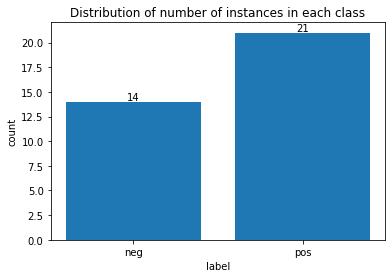

In [ ]:
labels_count = np.array([[label, eval_labels.count(label)] for label in set(eval_labels)])
labels_list = labels_count[:,0]
count_list = labels_count[:,1].astype(np.int)
plt.bar(labels_list, count_list)
plt.xlabel("label")
plt.ylabel("count")
plt.title("Distribution of number of instances in each class")
# display values above bars
for i in range(len(count_list)):
    plt.annotate(str(count_list[i]), xy=(labels_list[i],count_list[i]), ha='center', va='bottom')

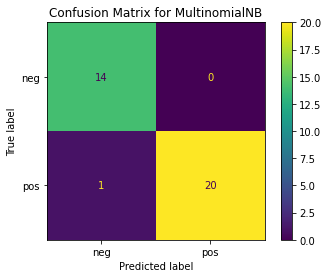

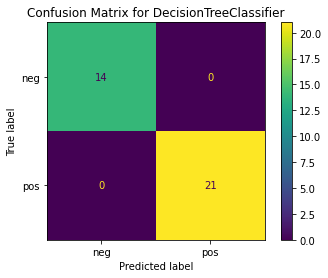

In [ ]:
test_model(nb_model, eval_rows, eval_feat, eval_labels, demo_file)
test_model(base_dt_model, eval_rows, eval_feat, eval_labels, demo_file)
test_model(best_dt_model, eval_rows, eval_feat, eval_labels, demo_file)

In [ ]:
analyze_errors(nb_model, eval_rows, eval_feat, eval_labels, eval_strings, vocab, demo_file)

### However, if we consider the evaluation datasets as validation, and now we are actually testing, then we are allowed to use the models that gave us best performance on the evaluation datasets. This should in theory give better results...(except for Base-DT as there is no optimization for it)

In [ ]:
test_model(nb_model_alt, eval_rows, eval_feat, eval_labels, demo_file)
test_model(base_dt_model, eval_rows, eval_feat, eval_labels, demo_file)
test_model(best_dt_model_alt, eval_rows, eval_feat, eval_labels, demo_file)

# Random stuff, will delete later

In [ ]:
voc1 = set([j for i in train_docs for j in i])#flattens documents and keeps unique values
print(len(voc1))

In [ ]:
voc2 = cv.get_feature_names()
print(len(voc2))

In [ ]:
print(set(voc1)-set(voc2))

In [ ]:
print(set(voc2)-set(voc1))
